In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout


In [2]:
# Adjust this path to where your UrbanSound8K metadata CSV is located
METADATA_PATH = 'metadata/UrbanSound8K.csv'

metadata = pd.read_csv(METADATA_PATH)


In [3]:
def extract_features(file_path, n_mfcc=13, hop_length=512, n_fft=2048, target_duration=4, sr=22050):
    try:
        # Load audio with target sampling rate
        audio, sample_rate = librosa.load(file_path, sr=sr)
        
        # Make audio length uniform (pad or trim)
        max_len = sr * target_duration
        if len(audio) < max_len:
            pad_width = max_len - len(audio)
            audio = np.pad(audio, (0, pad_width), mode='constant')
        else:
            audio = audio[:max_len]
        
        # Extract MFCC features (shape: n_mfcc x frames)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs = mfccs.T  # Transpose to shape: (frames, n_mfcc)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [4]:
AUDIO_PATH = r'D:\PROJECT11\audio'  # path to 'fold1', ..., 'fold10'

features = []
labels = []

for idx, row in metadata.iterrows():
    fold = f"fold{row['fold']}"  # Add 'fold' prefix here
    file_name = row['slice_file_name']
    file_path = os.path.join(AUDIO_PATH, fold, file_name)
    
    mfccs = extract_features(file_path)
    if mfccs is not None:
        features.append(mfccs)
        labels.append(row['classID'])


In [5]:
max_len = max(f.shape[0] for f in features)
X = np.array([np.pad(f, ((0, max_len - f.shape[0]), (0, 0)), mode='constant') for f in features])
y = np.array(labels)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Print Train and Test Sets
# Print shapes of train and test sets
print("Training set features (X_train) shape:", X_train.shape)
print("Training set labels (y_train) shape:", y_train.shape)
print("Testing set features (X_test) shape:", X_test.shape)
print("Testing set labels (y_test) shape:", y_test.shape)

# Print first few samples from X_train and y_train
print("\nFirst 2 samples of X_train (MFCC features):")
for i in range(min(2, X_train.shape[0])):  # Print up to 2 samples
    print(f"Sample {i}: shape {X_train[i].shape}, first frame: {X_train[i][0]}")
print("\nFirst 2 samples of y_train (labels):", y_train[:2])

# Print first few samples from X_test and y_test
print("\nFirst 2 samples of X_test (MFCC features):")
for i in range(min(2, X_test.shape[0])):  # Print up to 2 samples
    print(f"Sample {i}: shape {X_test[i].shape}, first frame: {X_test[i][0]}")
print("\nFirst 2 samples of y_test (labels):", y_test[:2])

Training set features (X_train) shape: (6985, 173, 13)
Training set labels (y_train) shape: (6985,)
Testing set features (X_test) shape: (1747, 173, 13)
Testing set labels (y_test) shape: (1747,)

First 2 samples of X_train (MFCC features):
Sample 0: shape (173, 13), first frame: [-111.36026    111.03993    -71.827545   -19.348228   -25.674389
    1.4367137   24.942066    14.2725725   -7.736783    11.507408
   -8.705351     8.029507     9.083717 ]
Sample 1: shape (173, 13), first frame: [-235.89902    130.23624     -6.3545265   18.188925   -19.575737
    8.451723    -7.6744566  -10.283913   -10.709337    -4.387236
  -17.699642   -19.673553   -14.750147 ]

First 2 samples of y_train (labels): [8 9]

First 2 samples of X_test (MFCC features):
Sample 0: shape (173, 13), first frame: [-108.141235   127.46521    -36.225887    13.002127     3.8808205
    6.251259    -2.073698    12.626109    -0.5543997   15.69194
    4.4628186    9.406599    -7.412883 ]
Sample 1: shape (173, 13), first frame

In [24]:
model_lstm = Sequential([
    LSTM(128, input_shape=(max_len, 13)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.2270 - loss: 2.1106 - val_accuracy: 0.4539 - val_loss: 1.5275
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.4208 - loss: 1.6071 - val_accuracy: 0.5518 - val_loss: 1.3239
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4736 - loss: 1.4562 - val_accuracy: 0.5907 - val_loss: 1.2325
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5329 - loss: 1.3432 - val_accuracy: 0.6302 - val_loss: 1.1286
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5647 - loss: 1.2639 - val_accuracy: 0.6308 - val_loss: 1.0954
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5907 - loss: 1.1962 - val_accuracy: 0.6691 - val_loss: 1.0260
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.6044 - loss: 1.1657 - val_accuracy: 0.6903 - val_loss: 0.9557
Epoch 8/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.6335 - loss: 1.1023 - 

In [15]:
model_lstm.save("lstm_model.keras")
model_lstm.save("lstm_model.h5")

d:\PROJECT11\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.2171 - loss: 2.1301 - val_accuracy: 0.4528 - val_loss: 1.5524
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4186 - loss: 1.6403 - val_accuracy: 0.5610 - val_loss: 1.3300
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.5032 - loss: 1.4549 - val_accuracy: 0.6056 - val_loss: 1.2040
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.5538 - loss: 1.3054 - val_accuracy: 0.6279 - val_loss: 1.1201
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.5686 - loss: 1.2761 - val_accuracy: 0.6434 - val_loss: 1.0765
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.5869 - loss: 1.2263 - val_accuracy: 0.6686 - val_loss: 1.0161
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.6105 - loss: 1.1558 - val_accuracy: 0.6766 - val_loss: 1.0061
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.6186 - loss: 1

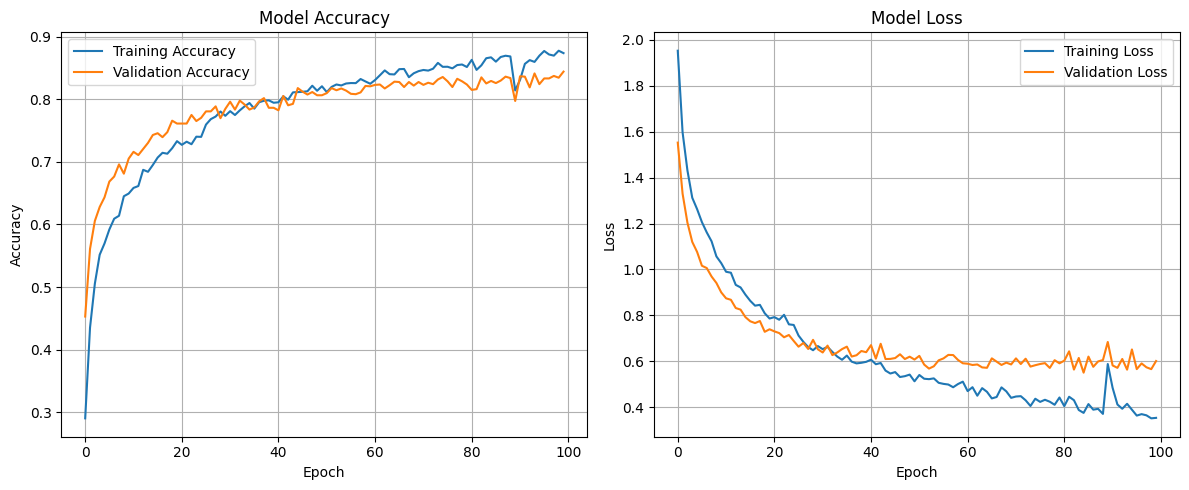

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define and compile the LSTM model
model_lstm = Sequential([
    LSTM(128, input_shape=(max_len, 13)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and store the history
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model_lstm.save('lstm_urbansound8k_model100.h5')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_plots100epoch.png')

In [16]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

#print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")





55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8471 - loss: 0.6039
Test Accuracy: 84.43%


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.2526 - loss: 2.0658 - val_accuracy: 0.5140 - val_loss: 1.3475
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.4712 - loss: 1.4977 - val_accuracy: 0.6108 - val_loss: 1.1867
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.5417 - loss: 1.3377 - val_accuracy: 0.6377 - val_loss: 1.0683
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.5761 - loss: 1.2314 - val_accuracy: 0.6737 - val_loss: 0.9926
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.5984 - loss: 1.1538 - val_accuracy: 0.6772 - val_loss: 0.9419
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.6553 - loss: 1.0292 - val_accuracy: 0.7041 - val_loss: 0.8980
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6439 - loss: 1.0527 - val_accuracy: 0.7207 - val_loss: 0.8343
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.6749 - loss: 0

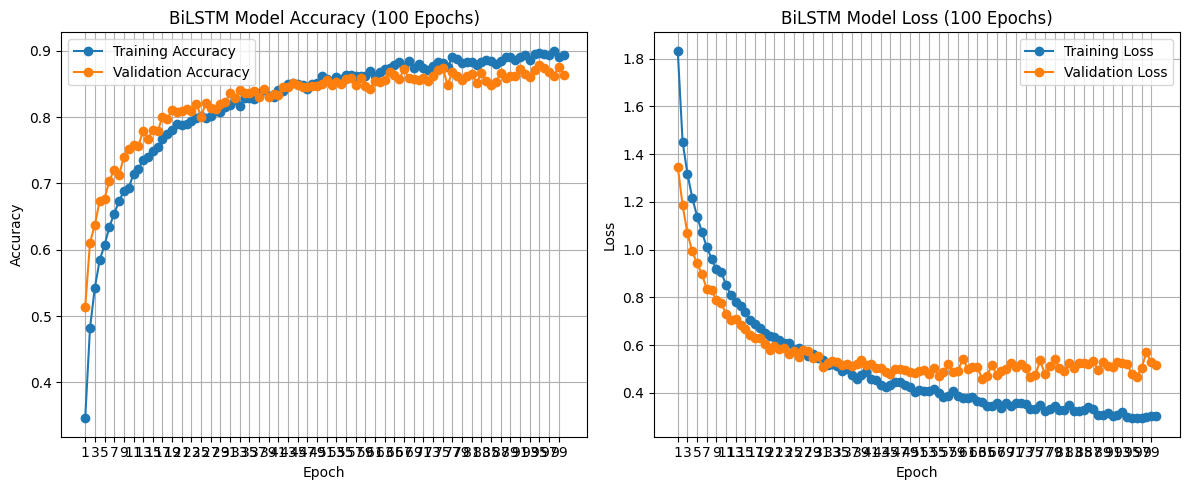

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense

# Define the BiLSTM model with Input layer
model_bilstm = Sequential([
    Input(shape=(max_len, 13)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Compile the model
model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model for 20 epochs
history = model_bilstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model_bilstm.save('bilstm_urbansound8k_model100.h5')

# Create figure for plots
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(range(1, 101), history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('BiLSTM Model Accuracy (100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 101, step=2))
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), history.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1, 101), history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('BiLSTM Model Loss (100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1, 101, step=2))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('bilstm_accuracy_loss_plots_100_epochs.png')
plt.show()

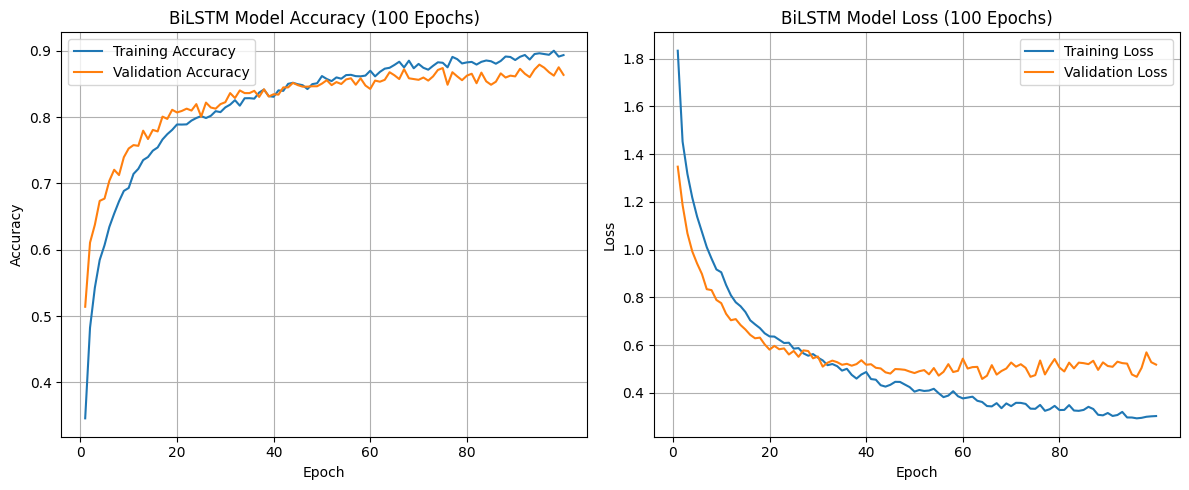

In [14]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), history.history['accuracy'], label='Training Accuracy' )
plt.plot(range(1, 101), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Model Accuracy (100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 100, step=20))
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), history.history['loss'], label='Training Loss')
plt.plot(range(1, 101), history.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Model Loss (100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 100, step=20))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('bilstm_accuracy_loss_plots_100_epochs.png')
plt.show()

In [15]:
test_loss, test_acc = model_bilstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8623 - loss: 0.5415
Test Accuracy: 86.38%


NameError: name 'val_acc' is not defined

In [16]:
import tensorflow as tf

model = tf.keras.models.load_model('D:/PROJECT11/backend/lstm_urbansound8k_model100.h5')
print("Model input shape:", model.input_shape)
model.summary()

Model input shape: (None, 173, 13)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,612 (318.80 KB)

 Trainable params: 81,610 (318.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)